<a href="https://colab.research.google.com/github/Natali-bali/TensorFlow_Tutorial/blob/master/07_Food_Vision_Big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone Project 1: 🍔👁 Food Vision Big™¶

We're going to be building Food Vision Big™, using all of the data from the Food101 dataset.

This time we've got the goal of beating DeepFood, a 2016 paper which used a Convolutional Neural Network trained for 2-3 days to achieve 77.4% top-1 accuracy.
https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment

Alongside attempting to beat the DeepFood paper, we're going to learn about two methods to significantly improve the speed of our model training:
- Prefetching
- Mixed precision training

What we're going to cover:
1. Using TensorFlow Datasets to download and explore data
2. Creating preprocessing function for our data
3. Batching & preparing datasets for modelling (making our datasets run fast)
4. Creating modelling callbacks
5. Setting up mixed precision training
6. Building a feature extraction model 
7. Fine-tuning the feature extraction model
8. Viewing training results on TensorBoard


In [4]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-af68bb21-92a7-839c-cabf-406c278af1b1)


For mixed precision training to work, you need access to a GPU with a compute compability score of 7.0+.

Google Colab offers P100, K80 and T4 GPUs, however, the P100 and K80 aren't compatible with mixed precision training.

Therefore before we proceed we need to make sure we have access to a Tesla T4 GPU in our Google Colab instance.

### Imports and helper functions

In [5]:
# Get helper functions
!wget 'https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py'

--2021-06-28 12:15:45--  https://raw.githubusercontent.com/Natali-bali/TensorFlow_Tutorial/master/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11000 (11K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.74K  --.-KB/s    in 0s      

2021-06-28 12:15:45 (101 MB/s) - ‘helper_functions.py.1’ saved [11000/11000]



In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Activation
# from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomHeight, RandomRotation, RandomZoom, RandomWidth

In [12]:
tf.__version__

'2.4.1'

### Get data
from tensorflow datasets

In [13]:
import tensorflow_datasets.public_api as tfds

In [14]:
# List all available datasets
datasets_list = tfds.list_builders()
print('food101' in datasets_list)

True


In [15]:
datasets_list[:10]

['abstract_reasoning',
 'accentdb',
 'aeslc',
 'aflw2k3d',
 'ag_news_subset',
 'ai2_arc',
 'ai2_arc_with_ir',
 'amazon_us_reviews',
 'anli',
 'arc']

In [56]:
#Load in the data
(train_data_, test_data_), ds_info = tfds.load(name = 'food101', 
                                             split = ['train', 'validation'],
                                             as_supervised = True,
                                             shuffle_files = True,
                                             with_info = True)

 Note: Calling the tfds.load() method will start to download a target dataset to disk if the download=True parameter is set (default). This dataset could be 100GB+, so make sure you have space.

In [57]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=101),
})

In [58]:
labels = ds_info.features['label'].names

In [59]:
labels[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [60]:
train_data_

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [61]:
train_data_.take(1)

<TakeDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [62]:
train_one_sample = train_data_.take(1)

In [63]:
for image, label in train_one_sample:
  print('Image shape:', image.shape)
  print('Image datatype:', image.dtype)
  print('Target class:', label)
  print('Class Name:', labels[label.numpy()])

Image shape: (512, 512, 3)
Image datatype: <dtype: 'uint8'>
Target class: tf.Tensor(18, shape=(), dtype=int64)
Class Name: chicken_curry


In [64]:
#Labels are not one hot encoded

In [65]:
image, tf.reduce_max(image), tf.reduce_min(image)

(<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
 array([[[170, 193, 165],
         [175, 198, 170],
         [187, 209, 186],
         ...,
         [253, 255, 249],
         [253, 255, 249],
         [253, 255, 249]],
 
        [[169, 185, 159],
         [169, 184, 161],
         [171, 189, 167],
         ...,
         [253, 255, 249],
         [253, 255, 249],
         [253, 255, 249]],
 
        [[166, 171, 151],
         [161, 166, 146],
         [158, 165, 147],
         ...,
         [253, 255, 249],
         [253, 255, 249],
         [253, 255, 249]],
 
        ...,
 
        [[143, 131, 105],
         [143, 131, 105],
         [141, 132, 103],
         ...,
         [152, 131, 104],
         [153, 129, 103],
         [151, 127, 101]],
 
        [[139, 129, 102],
         [138, 128, 101],
         [137, 128,  99],
         ...,
         [150, 126, 100],
         [151, 125, 100],
         [152, 126,  99]],
 
        [[133, 123,  96],
         [134, 124,  97],
         [136,

(-0.5, 511.5, 511.5, -0.5)

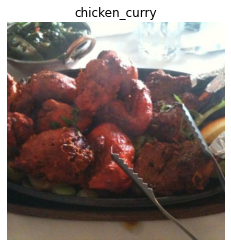

In [66]:
#Plot this picture
plt.imshow(image)
plt.title(labels[label.numpy()])
plt.axis(False)

### Make a function for preprocessing images

In [67]:
def prep_img(img, label, img_shape = 224):
  """
  Convert image datatype tp float32 and reshapes to [img_shape, img_shape, color]
  """
  img = tf.image.resize(img, [img_shape, img_shape])
  img = tf.cast(img, dtype = tf.float32)
  return img, label

In [68]:
img, label = prep_img(image, label)

In [70]:
img.shape

TensorShape([224, 224, 3])

### Batch and prepare datasets

In [71]:
#Map preprocessing function
train_data = train_data_.map(map_func=prep_img, num_parallel_calls=tf.data.AUTOTUNE) #num_parallel_calls=tf.data.AUTOTUNE to get all computing resurses
#Make butches and shuffle again
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)
#Same with test data
test_data = test_data_.map(map_func=prep_img, num_parallel_calls=tf.data.AUTOTUNE)
test_data = test_data.shuffle(buffer_size=1000).batch(batch_size = 32).prefetch(buffer_size = tf.data.AUTOTUNE)


In [72]:
train_data, test_data

(<PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>,
 <PrefetchDataset shapes: ((None, 224, 224, 3), (None,)), types: (tf.float32, tf.int64)>)

### Create modeling callbacks

In [73]:
def create_checkpoint(model_name):
  """Returns checkpoint callback function, args: model number"""
  checkpoint_filepath = 'checkpoints/checkpoint_'+model_name+'.ckpt'
  model_checkpoints = tf.keras.callbacks.ModelCheckpoint(checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
                                                          save_weights_only=True, save_freq='epoch',
                                                          options=None)
  return model_checkpoints

def early_stopping():
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                          min_delta=0, 
                                          patience=2, 
                                          verbose=0,
                                          mode='auto', 
                                          baseline=None, 
                                          restore_best_weights=False)
import datetime
def create_tf_board_callback(dir_name, experiment_name):
  log_dir = dir_name + '/' + experiment_name + '/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
  tensorflow_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f'Saving TensorBoard log files to {log_dir}')
  return tensorflow_callback

### Set up mixed precision training

In [74]:
import tensorflow
tensorflow.__version__

'2.4.1'

In [75]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

### Building feature extraction model

tf 2.5 has a bug, so we need to downgrade it to 2.4.1 version

In [76]:
#!pip3 install tensorflow==2.4.1

In [77]:
base_model = EfficientNetB0(include_top=False)
base_model.trainable = False

In [78]:
inputs = Input(shape = (224,224,3), name = 'input_layer')
gap_layer = GlobalAveragePooling2D(name = 'global_average_pooling')
dense = Dense(len(labels))
outputs = Activation(activation = 'softmax', dtype = tf.float32, name = 'output')

In [79]:
x = base_model(inputs, training = False)
x = gap_layer(x)
x = dense(x)
outputs = outputs(x)
model = Model(inputs, outputs)

In [80]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [81]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling (Glob (None, 1280)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 101)               129381    
_________________________________________________________________
output (Activation)          (None, 101)               0         
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [82]:
for layer in model.layers:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
global_average_pooling True float32 <Policy "mixed_float16">
dense_2 True float32 <Policy "mixed_float16">
output True float32 <Policy "float32">


In [83]:
history_features = model.fit(train_data,
                             epochs = 3,
                             validation_data = test_data,
                             steps_per_epoch = len(train_data),
                             validation_steps = int(0.15*len(test_data)),
                             callbacks = [create_checkpoint('feature_extr_1'),
                                          early_stopping(),
                                          create_tf_board_callback('efficientnetB0_full', 'feature_extr')])

Saving TensorBoard log files to efficientnetB0_full/feature_extr/20210628-124538
Epoch 1/3
2368/2368 [==============================] - 224s 79ms/step - loss: 2.3307 - accuracy: 0.4622 - val_loss: 1.2381 - val_accuracy: 0.6745

Epoch 00001: val_loss improved from inf to 1.23809, saving model to checkpoints/checkpoint_feature_extr_1.ckpt
Epoch 2/3
2368/2368 [==============================] - 172s 72ms/step - loss: 1.3099 - accuracy: 0.6619 - val_loss: 1.1201 - val_accuracy: 0.7002

Epoch 00002: val_loss improved from 1.23809 to 1.12013, saving model to checkpoints/checkpoint_feature_extr_1.ckpt
Epoch 3/3
2368/2368 [==============================] - 163s 68ms/step - loss: 1.1445 - accuracy: 0.7033 - val_loss: 1.0883 - val_accuracy: 0.7042

Epoch 00003: val_loss improved from 1.12013 to 1.08828, saving model to checkpoints/checkpoint_feature_extr_1.ckpt


In [85]:
def plot_loss_curves(history):
    """
    Args: TensorFlow model history object
    Returns: separate loss curves for training and validation metrics.
    """
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(len(history.history['loss']))

    #Plot Loss
    plt.plot(epochs, train_loss, label = 'Training Loss')
    plt.plot(epochs, val_loss, label = 'Validation Loss')
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.legend()

    #Plot Accuracy
    plt.figure()
    plt.plot(epochs, train_accuracy, label = 'Training Accuracy')
    plt.plot(epochs, val_accuracy, label = 'Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('epochs')
    plt.legend()

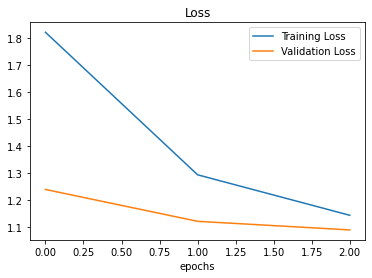

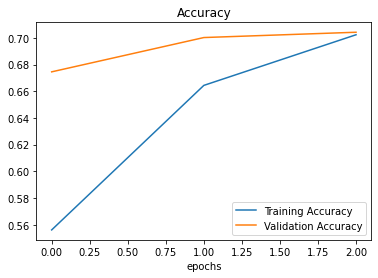

In [86]:
plot_loss_curves(history_features)

### Fine tuning our model

In [87]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
  layer.trainable = False


In [88]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

In [89]:
history_fine_tuned = model.fit(train_data, epochs = 5,
                               validation_data = train_data,
                               steps_per_epoch = len(train_data),
                               validation_steps = int(0.15*len(test_data)),
                               callbacks = [create_checkpoint('fine_tune'),
                                          early_stopping(),
                                          create_tf_board_callback('efficientnetB0_full', 'fine_tune')])

Saving TensorBoard log files to efficientnetB0_full/fine_tune/20210628-130732
Epoch 1/5
2368/2368 [==============================] - 178s 72ms/step - loss: 0.9762 - accuracy: 0.7409 - val_loss: 0.8492 - val_accuracy: 0.7728

Epoch 00001: val_loss improved from inf to 0.84916, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 2/5
2368/2368 [==============================] - 169s 71ms/step - loss: 0.8053 - accuracy: 0.7868 - val_loss: 0.7220 - val_accuracy: 0.8032

Epoch 00002: val_loss improved from 0.84916 to 0.72203, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 3/5
2368/2368 [==============================] - 167s 70ms/step - loss: 0.6920 - accuracy: 0.8169 - val_loss: 0.6253 - val_accuracy: 0.8369

Epoch 00003: val_loss improved from 0.72203 to 0.62530, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 4/5
2368/2368 [==============================] - 164s 69ms/step - loss: 0.5971 - accuracy: 0.8443 - val_loss: 0.5203 - val_accuracy: 0.8620

Epoch 00

In [91]:
model.evaluate(test_data)

790/790 [==============================] - 59s 72ms/step - loss: 1.0017 - accuracy: 0.7373


[1.0016885995864868, 0.7373069524765015]

In [96]:
from google.colab import drive
drive.mount('/content/gd')

Mounted at /content/gd


In [97]:
model.save('/content/gd/MyDrive/projects/SPICED/models/model_food101_full_2')

INFO:tensorflow:Assets written to: /content/gd/MyDrive/projects/SPICED/models/model_food101_full_2/assets


INFO:tensorflow:Assets written to: /content/gd/MyDrive/projects/SPICED/models/model_food101_full_2/assets


In [ ]:
#Train for another 5 epochs

In [98]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss = 'sparse_categorical_crossentropy',
              metrics = 'accuracy')

In [99]:
history_fine_tuned_2 = model.fit(train_data, epochs = 10,
                              initial_epoch=5,
                               validation_data = train_data,
                               steps_per_epoch = len(train_data),
                               validation_steps = int(0.15*len(test_data)),
                               callbacks = [create_checkpoint('fine_tune'),
                                          early_stopping(),
                                          create_tf_board_callback('efficientnetB0_full', 'fine_tune')])

Saving TensorBoard log files to efficientnetB0_full/fine_tune/20210628-134519
Epoch 6/10
2368/2368 [==============================] - 178s 72ms/step - loss: 0.4015 - accuracy: 0.9036 - val_loss: 0.3866 - val_accuracy: 0.9033

Epoch 00006: val_loss improved from inf to 0.38663, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 7/10
2368/2368 [==============================] - 169s 71ms/step - loss: 0.3739 - accuracy: 0.9126 - val_loss: 0.3967 - val_accuracy: 0.9068

Epoch 00007: val_loss did not improve from 0.38663
Epoch 8/10
2368/2368 [==============================] - 169s 71ms/step - loss: 0.3605 - accuracy: 0.9158 - val_loss: 0.3795 - val_accuracy: 0.9131

Epoch 00008: val_loss improved from 0.38663 to 0.37946, saving model to checkpoints/checkpoint_fine_tune.ckpt
Epoch 9/10
2368/2368 [==============================] - 169s 71ms/step - loss: 0.3515 - accuracy: 0.9200 - val_loss: 0.3547 - val_accuracy: 0.9137

Epoch 00009: val_loss improved from 0.37946 to 0.35474, saving 

In [103]:
result = model.evaluate(test_data)

790/790 [==============================] - 57s 70ms/step - loss: 1.0063 - accuracy: 0.7409


In [100]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compares two model history objects.
  """
  # Get original history measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  print(len(acc))

  val_acc = original_history.history["val_accuracy"]
  val_loss = original_history.history["val_loss"]

  # Combine original history with new history
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  print(len(total_acc))
  print(total_acc)

  # Make plots
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Training Accuracy')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Training Loss')
  plt.plot(total_val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1, initial_epochs-1],
            plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.xlabel('epoch')
  plt.show()

3
8
[0.5561320185661316, 0.664382815361023, 0.702297031879425, 0.7512211203575134, 0.7869439125061035, 0.8168448805809021, 0.8418745994567871, 0.8663366436958313]


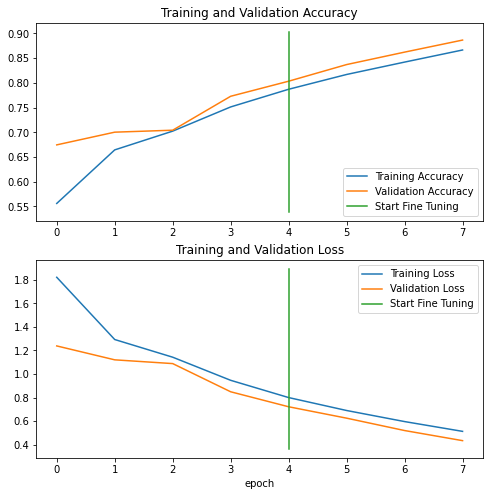

In [101]:
#History of feature extraction and fine tuning models
compare_historys(history_features, history_fine_tuned, initial_epochs=5)

5
10
[0.7512211203575134, 0.7869439125061035, 0.8168448805809021, 0.8418745994567871, 0.8663366436958313, 0.9092937111854553, 0.9148382544517517, 0.9185346364974976, 0.9214389324188232, 0.9237755537033081]


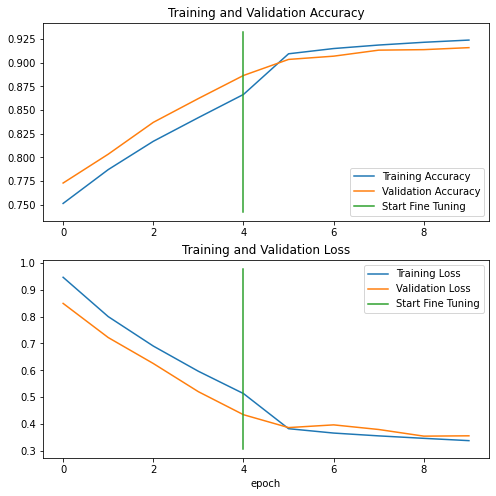

In [104]:
#Histories of fine tuning 1 and fine tuning 2
compare_historys(history_fine_tuned, history_fine_tuned_2,initial_epochs=5)

### ReduceLROnPlateau callback

In [102]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)